In [1]:
import itertools as it
import os
import pickle
import re
from copy import deepcopy
from functools import reduce
from glob import glob
from operator import add, itemgetter
from pprint import pprint

import gensim
import gensim.downloader as api
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.preprocessing import LabelEncoder, PowerTransformer

from utils import video_id_without_categories

wv = api.load('word2vec-google-news-300')

/home/hylomorph/Study/ped/yt_trending_videos/venv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Ground Truth

In [11]:
with open('data/category_id.pkl', 'rb') as fh:
    data = pickle.load(fh)

idx = [[(item['id'], int(item['snippet']['categoryId'])) for item in batch['items']] for batch in data]
idx = reduce(add, idx, [])

df = pd.read_pickle('data/chkp2.pkl')
unknown_idx = video_id_without_categories(df)
print("Liczba nieznanych kategorii")
print(unknown_idx.shape)

print("Filmy niedostępne na YouTube")
print(len(set(unknown_idx) - set(map(itemgetter(0),idx))))

Liczba nieznanych kategorii
(5768,)
Filmy niedostępne na YouTube
556


In [12]:
kaggle_df =  pd.concat([
    pd.read_csv(path, usecols=['video_id', 'category_id']) for path in glob('data/kaggle/*.csv')
]).groupby('video_id').max()

category_df = pd.DataFrame(np.array(idx), columns=['video_id', 'category_id']).set_index('video_id')
category_df = pd.concat([category_df, kaggle_df.loc[list(set(unknown_idx) - set(map(itemgetter(0),idx))), :]])
category_df['category_id'] = category_df.category_id.astype(int)
category_df

,category_id
video_id,
9wRQljFNDW8,17
Om_zGhJLZ5U,1
goP4Z5wyOlM,25
8NHA23f7LvU,24
IE-xepGLVt8,28
...,...
O3hz_DQ63No,22
abeqEEmpbdM,24
bqbWMgkvedI,26


# Analiza cech

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8606 entries, 9wRQljFNDW8 to 4YFo4bdMO8Q
Columns: 123 entries, trending_date to iqr_blue
dtypes: bool(5), datetime64[ns, UTC](1), datetime64[ns](3), float32(1), float64(45), int64(47), object(19), timedelta64[ns](2)
memory usage: 7.8+ MB


In [14]:
pd.options.display.max_columns = 1000
df.head(3)

,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_date_end,trending_date_start,trending_span,trending_span_days,publish_to_trending_span,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,emotions,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13 02:05:26+00:00,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,US,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,0 days 21:54:34,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,True,False,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03+00:00,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...,US,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,1 days 05:59:57,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.00

In [15]:
to_int = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'is_us', 'is_gb']
df[to_int] = df[to_int].astype(int)
df.head(3)

,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_date_end,trending_date_start,trending_span,trending_span_days,publish_to_trending_span,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,emotions,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13 02:05:26+00:00,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,US,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,0 days 21:54:34,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03+00:00,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,US,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,1 days 05:59:57,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,

In [16]:
to_ingore = ['trending_date', 'title', 'channel_title', 'publish_time', 'thumbnail_link', 
             'description', 'origin', 'trending_date_end', 'trending_date_start', 'trending_span', 'publish_to_trending_span',
             'emotions']

df.drop(to_ingore, axis=1, inplace=True)
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[person, person, person]","(person, 0.87004745)",person,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[tlsdw, scteen, long, didnt, watch, junkies]",68.507153,31.0,114.0,66.

### Liczenie wektorów cech dla kolumn z tekstem

In [17]:
text_to_process = ['image_text', 'tags', 'objects']

# Preprocess tags
stopwords_list = list(stopwords.words('english'))
def preprocess_tags(sentence):
    wordtokens = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
    wordtokens = [word for word in wordtokens if (word not in stopwords_list) and (len(word) > 2) and not (word.isnumeric())]
    return wordtokens

df['tags'] = df['tags'].apply(preprocess_tags)

df[text_to_process].head(3)

,image_text,tags,objects
video_id,,,
9wRQljFNDW8,"[brood, cantmiss, playe, lewis, yard, return, ...","[nfl, football, offense, defense, afc, nfc, am...","[person, person, person, person, person, perso..."
Om_zGhJLZ5U,"[tlsdw, scteen, long, didnt, watch, junkies]","[screenjunkies, screen, junkies, news, honest,...","[person, person, person]"
goP4Z5wyOlM,"[tehran, ahalabja, iraq, baghdad, iran, news]","[bbc, bbc, news, news, iran, iran, news, iraq,...",[]


In [18]:
df_temp = deepcopy(df[text_to_process])

def word_averaging(wv, sequence):
    mean = []
    try:
        for word in sequence:
            if word in wv.key_to_index:
                mean.append(wv.get_vector(word))
    except:
        return np.zeros(300,)
    if not mean: return np.zeros(300,)
    return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

def word_averaging_list(wv, sequences):
    return np.vstack([word_averaging(wv, w) for w in sequences])

def embedding_model(text, name):
    # Word averaging
    wa = word_averaging_list(wv, text)
    # Replace cols
    df_temp[name] = list(wa)

for col in text_to_process:
    embedding_model(df_temp[col].values, col)

df[text_to_process] = df_temp
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.87004745)",person,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153

### Przetworzenie pozostałych kolumn

In [19]:
to_encode = ['most_occurence_object']
df[to_encode] = LabelEncoder().fit_transform(df[to_encode].values.ravel())
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.5387666)",46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.87004745)",46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,11

In [20]:
to_untuple = ['max_prob_object']
df[to_untuple] = LabelEncoder().fit_transform(df[to_untuple].\
    applymap(lambda x: x[0] if isinstance(x, tuple) else 'none').fillna('none').values.ravel())
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0

### Sprawdzanie statystyk dla cech wektorowych

In [22]:
to_embeddings = ['description_embedding', 'title_embedding', 'feature_vector', 'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector']
import tqdm

embeddings_statistics = []
for col in tqdm.tqdm(to_embeddings):
    unwrapped_df = df[col].apply(lambda x: pd.Series(x, dtype='float32'))
    correlation = unwrapped_df.corrwith(df.category_id, method='spearman')
    correlation = correlation.describe()
    correlation['name'] = col
    embeddings_statistics.append(correlation)

100%|██████████| 7/7 [00:18<00:00,  2.63s/it]


<AxesSubplot:ylabel='name'>

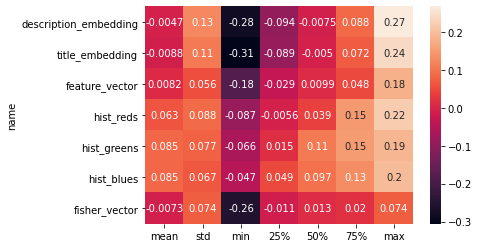

In [23]:
stats_df = pd.concat(embeddings_statistics, axis=1).T.set_index('name').astype('float32')
stats_df.drop('count', axis=1, inplace=True)
sns.heatmap(stats_df, annot=True)

### PCA dla cech wektorowych (TODO)

In [41]:
to_embeddings = ['description_embedding', 'title_embedding', 'feature_vector', 'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector']

from sklearn.decomposition import PCA

embeddings_statistics = []
for col in tqdm.tqdm(to_embeddings):
    unwrapped_df = df.loc[np.logical_not(df[col].isna()), col].apply(lambda x: pd.Series(x, dtype='float32'))
    unwrapped_df = pd.DataFrame(PCA().fit_transform(unwrapped_df.values))
    correlation = unwrapped_df.corrwith(df.category_id, method='spearman')
    correlation = correlation.describe()
    correlation['name'] = col
    embeddings_statistics.append(correlation)

100%|██████████| 7/7 [00:40<00:00,  5.76s/it]


### Zapisywanie pośredniego wyniku

In [43]:
df.to_pickle("data/chkp12.pkl")

### Wypełnianie brakująych kategorii

In [44]:
df = pd.read_pickle("data/chkp12.pkl")
df.head(2)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0

In [45]:
df['category_id'].isnull().any()

True

In [46]:
df = df.merge(category_df, on='video_id', how='left')
df['category_id'] = np.max(df[['category_id_x', 'category_id_y']], axis=1)
df.drop(labels=['category_id_x', 'category_id_y'], axis=1, inplace=True)
df.head(2)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0,17.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0,95

In [47]:
df['category_id'].isnull().any()

False

In [48]:
df.to_pickle("data/chkp12_filled.pkl")

### Usuwanie wartości NaN

In [120]:
df = pd.read_pickle("data/chkp12_filled.pkl")
embeddings_col = ['description_embedding', 'title_embedding', 'feature_vector', 
                  'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector', 
                  'tags', 'image_text', 'objects', 'category_text']
df.drop(embeddings_col, axis=1, inplace=True)

dist_matrix = nan_euclidean_distances(df.values, df.values)
dist_matrix.shape

(8606, 8606)

In [121]:
df_temp = deepcopy(df)

for i, (idx, row) in enumerate(df_temp.iterrows()):
    closest_idx = np.argmin(np.delete(dist_matrix[i,:], i))
    closest_case = df_temp.iloc[[closest_idx]]
    for col in row.index:
        if pd.isna(row[col]):
            df_temp.at[idx, col] = closest_case[col].values[0]
            if pd.isna(df_temp.at[idx, col]):
                df_temp.at[idx, col] = df_temp[col].mean()

df = df_temp
df.head(3)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,channel_title_hash,is_us,is_gb,people_amount,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,81377,655,25,177,0,0,0,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,-3.467289e+10,1,0,8.0,46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0,17.0
Om_zGhJLZ5U,288922,7515,792,2111,0,0,0,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,-2.138384e+10,1,0,3.0,46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0,95.0,1.0
goP4Z5wyOlM,34785,308,26,413,0,0,0,12,11,2017,6,4,21,16,40,14,11,2017,1,4,0,26,308,308,0,26,26,0,34785,34785,0,413,413,0,334,0.922156,0.077844,334,0.922156,0.077844,3,48,0,0,3,0,65,671,8,53,517,7,0.815385,0.770492,0.875000,0.000000,0.005803,0.0,10,90.0,2,6.0,0.066667,0.132075,0.160542,0.571429,1.664749e+11,1,0,0.0,43,77,6.982875,-33.0,8276.0,108845.0,119302.0,122061.0,122779.0,123187.0,129621.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.130231,232.0,217.5,163.158229,232.0,234.0,145.845683,195.0,209.0,25.0


Sprawdziliśmy wariancję dla wszystkich cech. Okazało się, że cecha `count_disgust` zawiera same zera, dlatego jej wariancja wynosiła 0.
Usuneliśmy tę cechę, bo nic nie wnosi.

In [122]:
df.var().sort_values()[:3]

count_disgust                    0.000000
channel_title_attention_ratio    0.000076
description_attention_ratio      0.000145
dtype: float64

In [123]:
df.drop('count_disgust', axis=1, inplace=True)
df.head(3)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,channel_title_hash,is_us,is_gb,people_amount,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,face_count,count_angry,count_sad,count_neutral,count_surprise,count_fear,count_happy,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,81377,655,25,177,0,0,0,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,-3.467289e+10,1,0,8.0,46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0,17.0
Om_zGhJLZ5U,288922,7515,792,2111,0,0,0,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,-2.138384e+10,1,0,3.0,46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0,95.0,1.0
goP4Z5wyOlM,34785,308,26,413,0,0,0,12,11,2017,6,4,21,16,40,14,11,2017,1,4,0,26,308,308,0,26,26,0,34785,34785,0,413,413,0,334,0.922156,0.077844,334,0.922156,0.077844,3,48,0,0,3,0,65,671,8,53,517,7,0.815385,0.770492,0.875000,0.000000,0.005803,0.0,10,90.0,2,6.0,0.066667,0.132075,0.160542,0.571429,1.664749e+11,1,0,0.0,43,77,6.982875,-33.0,8276.0,108845.0,119302.0,122061.0,122779.0,123187.0,129621.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.130231,232.0,217.5,163.158229,232.0,234.0,145.845683,195.0,209.0,25.0


## Macierz korelacji

Należy pamiętać, że **koeralcja to nie przyczynowość!**

- `trending_date_month` oraz `trending_date_year` są silnie odwrotnie skorelowane ze sobą. Jest tak dlatego, że dane nie poktrywają wszystkich miesiący, dlatego jeśli miesiąc jest np: grudźień to zawsze występuje w 2016, a styczeń zawsze w 2017.
- like i dislike (i cechy pochodne) są silnie odwrotnie skorelowane, bo zwykle likeów jest znacznie więcej niż dislików 
- cechy pochodne (np typu count -> ratio) są ze sobą silne skorelowane, ponieważ wywodzą się z tego samego miejsca.
- `is_gb` jest w pewnym stopniu skorelowane z `trending_span_days`

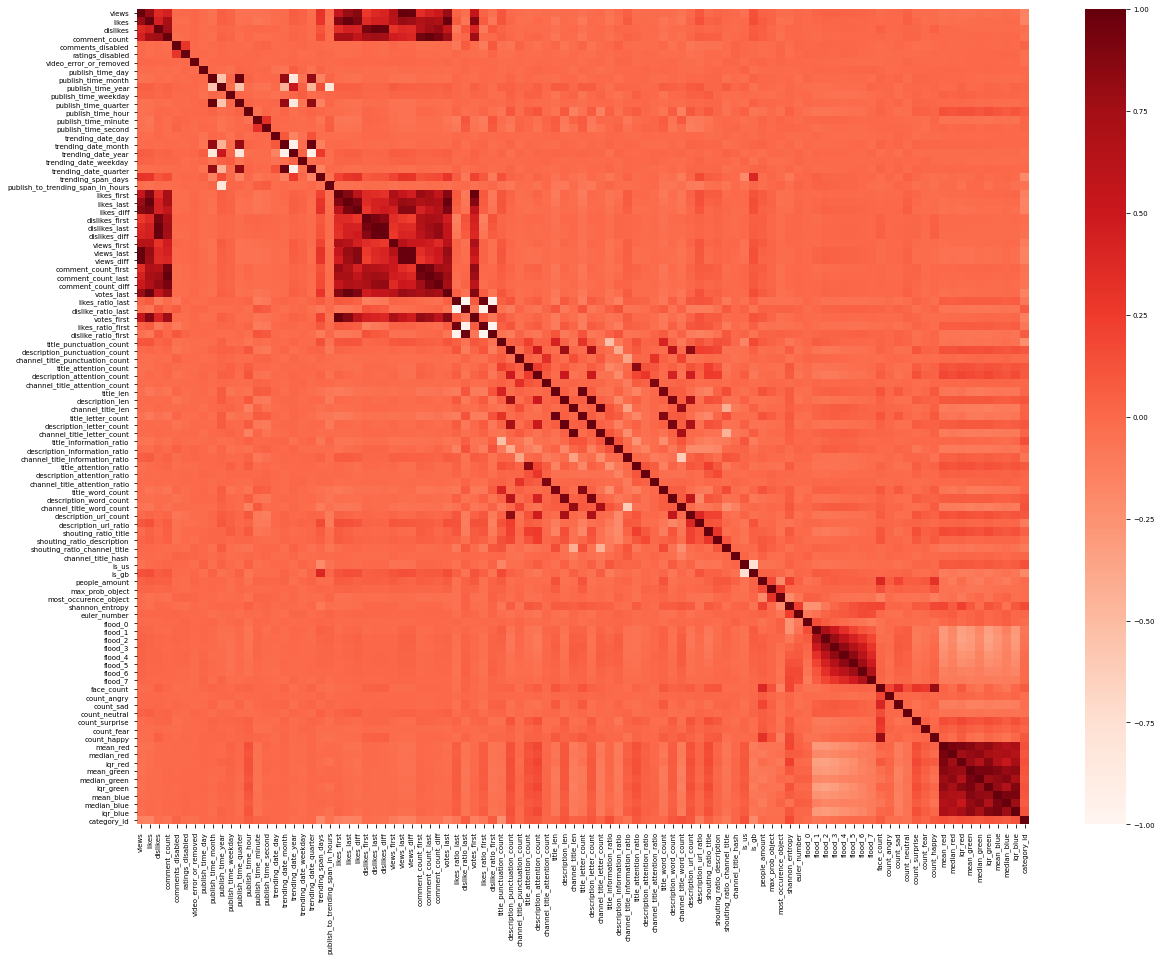

In [124]:
matplotlib.rcParams.update({'font.size': 7})
plt.figure(figsize=(20,15))
cor = df.loc[:, df.columns != 'count_disgust'].corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [125]:
cor_target = abs(cor["category_id"])
relevant_features = cor_target[cor_target>0.16]
relevant_features.sort_values(ascending=False)

category_id                1.000000
title_punctuation_count    0.229727
is_gb                      0.199770
trending_span_days         0.197725
shannon_entropy            0.169339
Name: category_id, dtype: float64

Należy usunąć wszystkie silnie skorelowane cechy (między sobą, a nie z wartością docelową) przed procesem uczenia - założenie m.in. regresji logistycznej

In [126]:
best_cols_pearson =  list(relevant_features.index)
for col1, col2 in it.combinations(best_cols_pearson, 2):
    print(df[[col1,col2]].corr())
    print('-'*50)

                         trending_span_days  title_punctuation_count
trending_span_days                 1.000000                 0.133744
title_punctuation_count            0.133744                 1.000000
--------------------------------------------------
                    trending_span_days     is_gb
trending_span_days            1.000000  0.395974
is_gb                         0.395974  1.000000
--------------------------------------------------
                    trending_span_days  shannon_entropy
trending_span_days             1.00000         -0.08641
shannon_entropy               -0.08641          1.00000
--------------------------------------------------
                    trending_span_days  category_id
trending_span_days            1.000000    -0.197725
category_id                  -0.197725     1.000000
--------------------------------------------------
                         title_punctuation_count     is_gb
title_punctuation_count                 1.000000  0.178211


### Normalizacja/standaryzacja danych

Używamy RoboustScaler, bo jest odporny na wartości odstające. Zamiast operować na średniej i odchyleniach, operuje na medianie i 25/75 kwantylem (IQR).

In [127]:
X_df, y_df = df.drop('category_id',1), df['category_id']

In [128]:
from sklearn.preprocessing import RobustScaler, StandardScaler

df.loc[:, df.columns != 'category_id' ] = RobustScaler(quantile_range=(5,95)).fit_transform(X_df.values)
df.head(3)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,channel_title_hash,is_us,is_gb,people_amount,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,face_count,count_angry,count_sad,count_neutral,count_surprise,count_fear,count_happy,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,-0.047171,-0.042619,-0.040205,-0.043771,0.0,0.0,0.0,-0.074074,0.636364,-1.0,-0.5,0.666667,-0.619048,-0.178571,0.181818,-0.037037,0.636364,-1.0,-0.333333,0.666667,-0.230769,-0.025424,-0.046341,-0.042779,-0.022369,-0.044524,-0.039991,-0.022996,-0.057940,-0.047263,-0.027998,-0.044188,-0.043792,-0.027646,-0.044171,-0.005987,0.005987,-0.048309,-0.034158,0.034158,1.2,0.262500,0.0,1.0,0.181818,0.0,0.558824,0.200279,-0.36,0.377358,0.199559,-0.380952,-0.562791,-0.101146,0.385185,0.413793,0.097863,0.0,0.636364,0.223016,-0.25,0.391304,0.164649,0.081481,-0.055331,0.861538,-0.023493,0.0,0.0,1.4,0.000000,0.00000,0.213723,-0.181132,0.078947,-0.093196,0.380827,0.220693,0.088947,-0.082086,-0.120494,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,-0.013582,0.057592,-0.044554,-0.230157,-0.124242,-0.270782,-0.284435,-0.209877,-0.313823,17.0
Om_zGhJLZ5U,-0.022875,-0.014879,0.038462,0.037665,0.0,0.0,0.0,-0.111111,0.636364,-1.0,0.5,0.666667,0.142857,-0.267857,-0.236364,-0.037037,0.636364,-1.0,-0.333333,0.666667,-0.230769,0.008475,0.002435,-0.015039,-0.022369,0.133341,0.038157,-0.022996,0.015402,-0.022998,-0.027998,0.079309,0.037644,-0.027646,-0.014417,-0.217287,0.217287,0.004614,-0.271378,0.271378,0.0,-0.170833,0.0,0.0,0.181818,0.0,-0.029412,-0.141748,0.08,-0.018868,-0.138396,0.095238,0.060870,0.044155,0.013757,0.000000,0.558418,0.0,0.090909,-0.108649,0.00,-0.130435,0.032266,0.162563,-0.174465,-0.049704,-0.009383,0.0,0.0,0.4,0.000000,0.00000,0.060673,-0.364420,0.071429,-0.132936,-0.297077,-0.405169,-0.378368,0.026306,0.000000,0.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,-0.155513,-0.193717,-0.143564,-0.101301,-0.154545,-0.047148,-0.160596,-0.191358,-0.119552,1.0
goP4Z5wyOlM,-0.052626,-0.044022,-0.040103,-0.033833,0.0,0.0,0.0,-0.111111,0.636364,-1.0,0.5,0.666667,0.285714,0.017857,0.436364,-0.037037,0.636364,-1.0,-0.333333,0.666667,-0.230769,-0.004237,-0.048808,-0.044182,-0.022369,-0.044292,-0.039889,-0.022996,-0.074405,-0.052710,-0.027998,-0.029118,-0.033854,-0.027646,-0.045520,-0.154171,0.154171,-0.050710,-0.200520,0.200520,0.2,-0.066667,0.0,0.0,0.181818,0.0,0.250000,-0.032252,-0.16,0.283019,-0.031619,-0.190476,0.113846,-0.075660,-0.264815,0.000000,0.287376,0.0,0.181818,-0.025733,0.00,-0.043478,0.038095,-0.072956,0.239665,0.

# Wybieranie cech
### Funkcja podsumowująca rankingi

In [156]:
from typing import Callable, List, Tuple
from collections import defaultdict
from operator import itemgetter

def combine_rankings(rankings: List[pd.Series]):
    scores = defaultdict(int)
    for ranking in rankings:
        for name, rank in zip(ranking.index, ranking):
            scores[name] += rank

    return sorted(scores.items(), key=itemgetter(1))

names = ['a','b','c','d']
combine_rankings([
        pd.Series([0,1,2,3], index=names),
        pd.Series([1,0,3,2], index=names)
])

[('a', 1), ('b', 1), ('c', 5), ('d', 5)]

In [148]:
from sklearn.feature_selection import VarianceThreshold

def rank_by_variance(df, threshold=0.01, target_name = 'category_id'):
    features = df.drop(target_name, axis=1)
    variances = features.var()
    return pd.Series(variances > threshold, index=features.columns, dtype=np.uint8)

rank_by_variance(df).sort_values()

channel_title_attention_count    0
ratings_disabled                 0
video_error_or_removed           0
channel_title_attention_ratio    0
views                            1
                                ..
views_last                       1
views_first                      1
dislikes_diff                    1
dislike_ratio_last               1
iqr_blue                         1
Length: 98, dtype: uint8

In [151]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

def rank_by_function(df, score_func, ascending=True, target_name = 'category_id'):
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    fs = SelectKBest(score_func=score_func, k='all')
    fs.fit_transform(X, y)
    
    series = pd.Series(fs.scores_, index=X.columns).sort_values(ascending=ascending)
    return pd.Series(range(len(series)), index=series.index)

In [152]:
rank_by_function(df, score_func=f_classif, ascending=False)

shouting_ratio_channel_title     0
dislike_ratio_last               1
likes_ratio_last                 2
likes_ratio_first                3
dislike_ratio_first              4
                                ..
flood_0                         93
publish_time_day                94
video_error_or_removed          95
trending_date_weekday           96
trending_date_day               97
Length: 98, dtype: int64

#### Mutual Information Feature Selection
https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [153]:
rank_by_function(df, score_func=mutual_info_classif, ascending=False)

channel_title_hash                  0
shouting_ratio_channel_title        1
channel_title_len                   2
channel_title_information_ratio     3
channel_title_letter_count          4
                                   ..
trending_date_weekday              93
ratings_disabled                   94
video_error_or_removed             95
publish_time_year                  96
trending_date_year                 97
Length: 98, dtype: int64

In [154]:
rank_by_function(np.abs(df), score_func=chi2, ascending=False)

publish_to_trending_span_in_hours     0
views_diff                            1
flood_0                               2
views                                 3
views_last                            4
                                     ..
channel_title_attention_ratio        93
publish_time_minute                  94
publish_time_second                  95
trending_date_day                    96
publish_time_day                     97
Length: 98, dtype: int64

In [161]:
def rank_by_rfe(df, n_features = 3, target_name = 'category_id'):
    X, y = df.drop(target_name, axis=1), df[target_name]

    lr = LogisticRegression()
    rfe = RFE(lr, n_features_to_select=X.shape[1]-1)
    X_rfe = rfe.fit_transform(X, y)
    lr.fit(X_rfe, y)

    return pd.Series(rfe.support_, index = X_df.columns)
    # rfe_cols = rfe_temp[rfe_temp == True].index.tolist()
    # rfe_cols

# rank_by_rfe(df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


shouting_ratio_channel_title      0
channel_title_len                 1
channel_title_letter_count        2
channel_title_hash                3
shouting_ratio_title              4
                                 ..
comments_disabled                93
channel_title_attention_ratio    94
channel_title_attention_count    95
ratings_disabled                 96
video_error_or_removed           97
Length: 98, dtype: int64

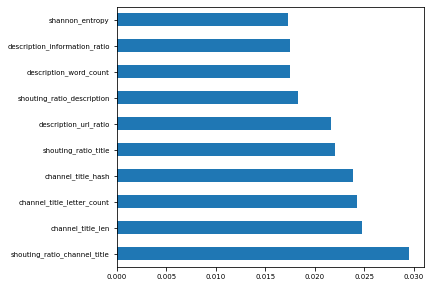

In [166]:
def rank_by_clf_importance(df, clf, ascending=False, target_name = 'category_id', ranking=True):
    X, y = df.drop(target_name, axis=1), df[target_name]
    clf.fit(X, y)
    if not ranking:
        return pd.Series(clf.feature_importances_, index=X.columns)
    else:
        series = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=ascending)
        return pd.Series(range(len(series)), index=series.index)


clf = RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)
rank_by_clf_importance(df, clf, ranking=False).nlargest(10).plot(kind='barh')
plt.tight_layout()
plt.grid(False)
plt.plot()

rank_by_clf_importance(df, clf, ranking=True)

In [167]:
from sklearn.ensemble import ExtraTreesClassifier

combine_rankings([
    # rank_by_variance(df).index,
    rank_by_function(df, score_func=f_classif, ascending=False),
    rank_by_function(df, score_func=mutual_info_classif, ascending=False),
    rank_by_clf_importance(df, RandomForestClassifier(n_jobs=-1, random_state=42)),
    rank_by_clf_importance(df, ExtraTreesClassifier(n_jobs=-1, random_state=42))
    # rank_by_function(np.abs(df), score_func=chi2, ascending=False).index,
])[:10]

[('shouting_ratio_channel_title', 1),
 ('channel_title_letter_count', 27),
 ('channel_title_len', 27),
 ('description_url_ratio', 28),
 ('shouting_ratio_title', 33),
 ('mean_red', 58),
 ('description_punctuation_count', 61),
 ('likes_ratio_first', 62),
 ('channel_title_hash', 64),
 ('dislike_ratio_first', 66)]

## Istotność trójek cech oparta o strukturę hipergrafową

In [138]:
# from hypper.hypergraph import HyperGraph
# from hypper.preprocessing import Preprocess

# df_pp = Preprocess(df).run_discretization(method='sturges', label_to_ignore=None)
# hg = HyperGraph(df_pp, label='category_id')
# with open('data/hypergraph_strucutre.pkl', 'wb') as handle:
#     pickle.dump(hg, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/hypergraph_strucutre.pkl', 'rb') as handle:
    hg = pickle.load(handle)

rw = hg.random_walk(iterations=1000000)

100%|██████████| 1000000/1000000 [01:27<00:00, 11399.99it/s]


In [139]:
for i, ((f1, f2, f3), _) in enumerate(rw.most_common(10)):
    print(f'{i+1}. {hg.edges[f1]} - {hg.edges[f2]} - {hg.edges[f3]}')

1. ratings_disabled_0.0 - title_attention_count_0.0 - channel_title_attention_count_0.0
2. dislikes_22101.94318181818 - channel_title_attention_count_0.0 - count_disgust_0.0
3. dislikes_22101.94318181818 - channel_title_punctuation_count_0.0 - count_fear_0.0
4. views_diff_3804811.8181818184 - description_attention_ratio_0.008522727272727272 - count_disgust_0.0
5. views_last_4824858.465909091 - comment_count_diff_-6472.738636363636 - count_angry_0.0
6. views_4824858.465909091 - likes_diff_-14498.102272727272 - votes_last_66186.39772727272
7. comment_count_18482.965909090908 - views_last_4824858.465909091 - votes_first_44917.931818181816
8. dislikes_first_7149.125 - comment_count_last_18482.965909090908 - count_disgust_0.0
9. views_last_4824858.465909091 - comment_count_diff_-6472.738636363636 - votes_first_44917.931818181816
10. views_last_4824858.465909091 - comment_count_last_18482.965909090908 - channel_title_attention_ratio_0.0
